# Dataset

In [1]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from  sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
random_state = 0

# 測試clean data實做classifier來 predict Esun dataset to data cleaning

# Image denoise

In [2]:
def get_bin_table(threshold=100):
    table = []
    for i in range(256):
        if i < threshold:
            table.append(0)
        else:
            table.append(1)
    return table

def remove_noise_pixel(img, noise_point_list):
    for item in noise_point_list:
        img.putpixel((item[0], item[1]), 1)

def collect_noise_point(img):
    noise_point_list = []
    for x in range(img.width):
        for y in range(img.height):
            res_9 = sum_9_region_new(img, x, y)
            if (0 < res_9 < 3) and img.getpixel((x, y)) == 0:
                pos = (x, y)
                noise_point_list.append(pos)
    return noise_point_list

def sum_9_region_new(img, x, y):
    cur_pixel = img.getpixel((x, y))
    width = img.width
    height = img.height
    if cur_pixel == 1:
        return 0
    if y < 3:
        return 1
    elif y > height - 3:
        return 1
    else:
        if x < 3:
            return 1
        elif x == width - 1:
            return 1
        else:
            sum = img.getpixel((x - 1, y - 1)) \
                  + img.getpixel((x - 1, y)) \
                  + img.getpixel((x - 1, y + 1)) \
                  + img.getpixel((x, y - 1)) \
                  + cur_pixel \
                  + img.getpixel((x, y + 1)) \
                  + img.getpixel((x + 1, y - 1)) \
                  + img.getpixel((x + 1, y)) \
                  + img.getpixel((x + 1, y + 1))
            return 9 - sum

# Load traing Image

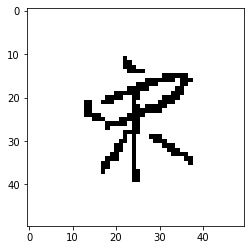

In [3]:
img_list = []
data_path = "./clean_data/"#label dir 
folder_list = os.listdir(data_path)
folder_list.sort(key=lambda x: int(x))
num_class = 1
for i in folder_list[:num_class]:
    im_list = os.listdir(data_path+i)
    for file in im_list:
        file_name = data_path+i+"/"+file
        img_list.append((file_name,int(i)))    
            
plt.imshow(Image.open(img_list[0][0]),cmap='gray')

train_img = []
train_label = []
for file,label in img_list:
    img  = Image.open(file).convert('L').resize((67,67),Image.BILINEAR)
    train_label.append(label)
    train_img.append(np.array(img).reshape(-1))

# Load test Image

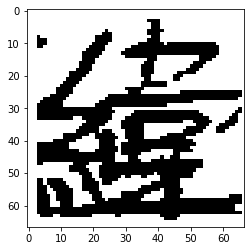

In [4]:
img_list = []
data_path = '/home/yehchehsin/Desktop/ESunBank_Competition/each_label/'
#label dir 
folder_list = os.listdir(data_path)
folder_list.sort(key=lambda x: int(x))
num_class = 1
for i in folder_list[6]:
    im_list = os.listdir(data_path+i)
    for file in im_list:
        file_name = data_path+i+"/"+file
        img_list.append((file_name,int(i)))    
            


test_img = []
test_label = []
total_img = []
for file,label in img_list:
    img  = Image.open(file).resize((67,67),Image.BILINEAR)
    test_label.append(label)
    im = np.array(img).reshape(-1)
    table = get_bin_table(np.mean(im))
    binary = img.point(table, '1')
    noise_point_list = collect_noise_point(binary)
    remove_noise_pixel(binary, noise_point_list)
    im = np.array(binary).reshape(-1)
    test_img.append(im)

    
plt.imshow(binary,cmap='gray')
test_img = np.array(test_img)
test_label = np.array(test_label)


In [5]:
X_train,X_test,Y_train,Y_test = train_test_split(total_img,total_label,test_size=0.8,random_state=0)

NameError: name 'total_label' is not defined

# predict function

In [6]:
def predict_accuracy(y, y_hat):
    return sum(y == y_hat) / y.shape[0]

# Use Kmean data cleaning

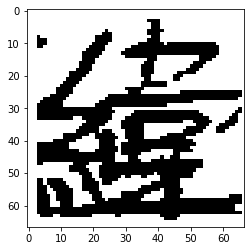

In [7]:
img_list = []
data_path = '/home/yehchehsin/Desktop/ESunBank_Competition/each_label/'
#label dir 
folder_list = os.listdir(data_path)
folder_list.sort(key=lambda x: int(x))
num_class = 3
for i in folder_list[6]:
    im_list = os.listdir(data_path+i)
    for file in im_list:
        file_name = data_path+i+"/"+file
        img_list.append((file_name,int(i)))    
            


test_img = []
test_label = []
total_img = []
for file,label in img_list:
    img  = Image.open(file).resize((67,67),Image.BILINEAR)
    test_label.append(label)
    im = np.array(img).reshape(-1)
    table = get_bin_table(np.mean(im))
    binary = img.point(table, '1')
    noise_point_list = collect_noise_point(binary)
    remove_noise_pixel(binary, noise_point_list)
    im = np.array(binary).reshape(-1)
    test_img.append(im)

    
plt.imshow(binary,cmap='gray')
test_img = np.array(test_img)
test_label = np.array(test_label)


In [8]:
from sklearn.cluster import KMeans
import collections
reduced_data = PCA(n_components=2).fit_transform(test_img)
#kmeans = KMeans(init="k-means++", n_clusters=800, n_init=10, n_jobs=4, max_iter=1000, algorithm='elkan')
kmeans = KMeans(init="k-means++",n_clusters=2, n_init=10, n_jobs=4, max_iter=10000, algorithm='auto')

kmeans.fit(reduced_data)


result = collections.defaultdict(list)
for i,file in enumerate(img_list):
    result[kmeans.labels_[i]].append(file[0])
kmean_res =result[1] if len(result[0])<len(result[1])else result[0]
 

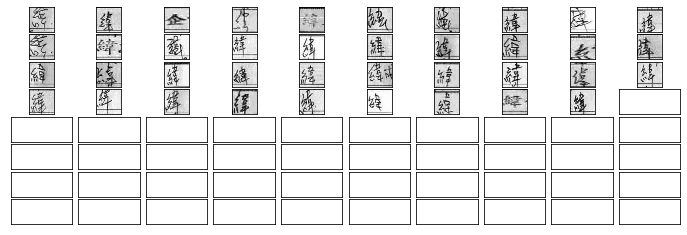

In [9]:
fig, axes = plt.subplots(8,10, figsize=(12, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    if i<len(result[0]):
        file = result[0][i]
        c = Image.open(file).resize((50,50))
        ax.imshow(c,cmap='gray')

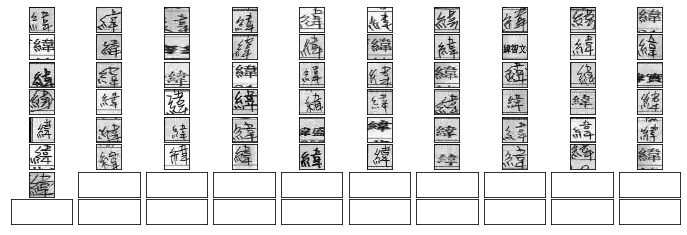

In [10]:
fig, axes = plt.subplots(8, 10, figsize=(12, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    if i<len(result[1]):
        file = result[1][i]
        c = Image.open(file).resize((50,50))
        ax.imshow(c,cmap='gray')

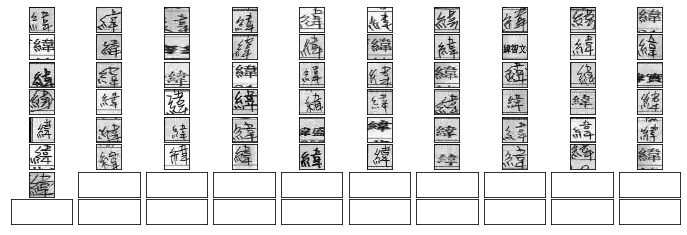

In [11]:
fig, axes = plt.subplots(8, 10, figsize=(12, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    if i<len(kmean_res):
        file = kmean_res[i]
        c = Image.open(file).resize((50,50))
        ax.imshow(c,cmap='gray')

In [12]:
# from sklearn.cluster import KMeans
# import collections
# import shutil

# data_path = '/home/yehchehsin/Desktop/ESunBank_Competition/each_label/'
# #label dir 
# folder_list = os.listdir(data_path)
# folder_list.sort(key=lambda x: int(x))

# k_path = './k_mean_data/'

# for j in range(0,50):
#     img_list = []
#     im_list = os.listdir(data_path+str(j))
#     for file in im_list:
#         file_name = data_path+str(j)+"/"+file
#         img_list.append((file_name,int(j)))    
    


#     test_img = []
#     test_label = []
#     total_img = []
#     for file,label in img_list:
#         img  = Image.open(file).resize((67,67),Image.BILINEAR)
#         test_label.append(label)
#         im = np.array(img).reshape(-1)
#         table = get_bin_table(np.mean(im))
#         binary = img.point(table, '1')
#         noise_point_list = collect_noise_point(binary)
#         remove_noise_pixel(binary, noise_point_list)
#         im = np.array(binary).reshape(-1)
#         test_img.append(im)


#     plt.imshow(binary,cmap='gray')
#     test_img = np.array(test_img)
#     test_label = np.array(test_label)

#     reduced_data = PCA(n_components=2).fit_transform(test_img)
#     #kmeans = KMeans(init="k-means++", n_clusters=800, n_init=10, n_jobs=4, max_iter=1000, algorithm='elkan')
#     kmeans = KMeans(init="k-means++",n_clusters=2, n_init=10, n_jobs=4, max_iter=10000, algorithm='auto')

#     kmeans.fit(reduced_data)


#     result = collections.defaultdict(list)
    
#     for i,file in enumerate(img_list):
#         result[kmeans.labels_[i]].append(file[0])
    
#     kmean_res =result[1] if len(result[0])<len(result[1])else result[0]
#     if not os.path.exists(k_path+str(j)):
#         os.mkdir(k_path+str(j))
#     for file in kmean_res:
#         shutil.copyfile(file,k_path+str(j)+'/'+file.split("/")[7])
        
        
        
        
